In [1]:
import base64, os
import multihash as mh
import hashlib as hl  
from dataclasses import dataclass

## Kademlia key implementation taken from https://github.com/libp2p/py-libp2p-xor/blob/master/key/key.py

In [2]:
# bits_in_byte returns a list of bits in a byte, in descending order of significance.
def bits_in_byte(byte):
    return [
        byte & 0x80 != 0,
        byte & 0x40 != 0,
        byte & 0x20 != 0,
        byte & 0x10 != 0,
        byte & 0x8 != 0,
        byte & 0x4 != 0,
        byte & 0x2 != 0,
        byte & 0x1 != 0,
    ]


class Key(bytes):
    def bit_len(self):
        return len(self) * 8

    def bit_at(self, offset):
        return self[offset // 8] & (1 << (7 - offset % 8))

    def to_float(self):
        f = 0.0
        s = 1.0
        for byte in self:
            for bit in bits_in_byte(byte):
                s /= 2.0
                if bit:
                    f += s
        return f

    def __eq__(self, other):
        if isinstance(other, Key):
            return self.hex() == other.hex()
        else:
            return False

    def __hash__(self):
        return hash(self.hex())

    def __str__(self):
        return self.hex()


def choose_key(n):
    return Key(bytearray(os.urandom(n)))


def xor_key(x: Key, y: Key):
    return Key(bytes([x[k] ^ y[k] for k in range(len(x))]))


def key_from_base64_kbucket_id_optional(s: str):
    return key_from_base64_kbucket_id(s) if s else None


def key_from_base64_kbucket_id(s: str):
    return Key(base64.b64decode(s))

## Useful helper functions

In [3]:
def bytes_to_bit_string(data: bytes) -> str:
    return "".join(f'{byte:08b}' for byte in data)
  
def multihash_to_kad_id(peer_id: str) -> bytes:  
    multi_hash = mh.from_b58_string(peer_id)
    return hl.sha256(multi_hash).digest()
# this should be a clean way (even if it could be done in less lines it is more readable)
def xor_distance(bytes0: bytes, bytes1: bytes):
    xor=bytearray()
    maxlen=max(len(bytes0), len(bytes1))

    for i in range(maxlen):
        byte0 = bytes0[i if len(bytes0)>len(bytes1) else i-len(bytes1)+len(bytes0)] if i >= maxlen-len(bytes0) else 0
        byte1 = bytes1[i if len(bytes1)>len(bytes0) else i-len(bytes0)+len(bytes1)] if i >= maxlen-len(bytes1) else 0
        xor.append(byte0 ^ byte1)

    return bytes(xor)

# get the corresponding k-bucket for the given XOR distance in bytes
def bucket_number_for_distance(d: bytes) -> int:
    count=0
    # iterate on the bytes from left to right
    for b in d:
        # while the byte==0, add 8 (bits) to the counter
        count+=8
        if b!=0:
            # at the first non null byte, shift right until this byte==0
            while b!=0:
                b>>=1
                # for each right shift, remove 1 to counter
                count-=1
            break
    # return the length of the byte string minus the number of leading 0 bits
    return 8*len(d)-count


##### TESTING METHODS #####

def bitstring_to_bytes(s):
    v = int(s, 2)
    b = bytearray()
    while v:
        b.append(v & 0xff)
        v >>= 8
    return bytes(b[::-1])

## XOR trie implementation taken from https://github.com/libp2p/py-libp2p-xor/blob/master/trie/trie.py

In [4]:
@dataclass
class Trie1:
    branch: (any, any)
    key: Key

    def __init__(self):
        self.branch = (None, None)
        self.key = None

    def is_empty(self):
        return not self.key

    def is_leaf(self):
        return not self.branch[0] and not self.branch[1]

    def is_empty_leaf(self):
        return self.is_empty() and self.is_leaf()

    def is_non_empty_leaf(self):
        return not self.is_empty() and self.is_leaf()

    def size(self):
        return self.size_at_depth(0)

    def size_at_depth(self, depth):
        if self.is_leaf():
            return 0 if self.is_empty() else 1
        else:
            return self.branch[0].size_at_depth(depth + 1) + self.branch[1].size_at_depth(depth + 1)

    def add(self, key):
        return self.add_at_depth(0, key)

    def add_at_depth(self, depth, key):
        if self.is_empty_leaf():
            self.key = key
            return depth, True
        elif self.is_non_empty_leaf():
            if key == self.key:
                # key already in trie
                return depth, False
            else:
                p = self.key
                self.key = None
                self.branch = (Trie(), Trie())
                self.branch[p.bit_at(depth)].key = p
                return self.branch[key.bit_at(depth)].add_at_depth(depth + 1, key)
        else:
            return self.branch[key.bit_at(depth)].add_at_depth(depth + 1, key)

    def remove(self, key):
        return self.remove_at_depth(0, key)

    def remove_at_depth(self, depth, key):
        if self.is_empty_leaf():
            return depth, False
        elif self.is_non_empty_leaf():
            self.key = None
            return depth, True
        else:
            d, removed = self.branch[key.bit_at(depth)].remove_at_depth(depth + 1, key)
            if removed:
                self.shrink()
                return d, True
            else:
                return d, False

    def find(self, key):
        return self.find_at_depth(0, key)

    def find_at_depth(self, depth, key):
        if self.is_empty_leaf():
            return None, depth
        elif self.is_non_empty_leaf():
            return self.key, depth
        else:
            return self.branch[key.bit_at(depth)].find_at_depth(depth + 1, key)

    def list_of_depths(self):
        return self.list_of_depths_at_depth(0)

    def list_of_depths_at_depth(self, depth):
        if self.is_empty_leaf():
            return []
        elif self.is_non_empty_leaf():
            return [depth]
        else:
            l0 = self.branch[0].list_of_depths_at_depth(depth + 1)
            l1 = self.branch[1].list_of_depths_at_depth(depth + 1)
            return l0 + l1

    def shrink(self):
        b0, b1 = self.branch[0], self.branch[1]
        if b0.is_empty_leaf() and b1.is_empty_leaf():
            self.branch = (None, None)
        elif b0.is_empty_leaf() and b1.is_non_empty_leaf():
            self.key = b1.key
            self.branch = (None, None)
        elif b0.is_non_empty_leaf() and b1.is_empty_leaf():
            self.key = b0.key
            self.branch = (None, None)

## Peer class

In [5]:
class Peer(object):

    def __init__(self, index, key, neighbors, buckets, alive):
        self.index = index # not necessary, but convienient to work with Nebula Crawler
        self.key = key
        # neighbors ordered from closer to farthest
        # TODO: or the other way round?
        self.neighbors = neighbors
        # bucket 0 contains the farthest peers (full), high buckets are empty
        # TODO: dictionary?
        self.buckets = buckets
        self.alive = alive
                
    def distance(self, p):
        return xor_key(self.key, p.key)
        


## Nebula Crawler database queries

In [6]:
import psycopg2

# query to connect to the postgresql db
postgres_connect_query="host=127.0.0.1 dbname=nebula user=nebula password=password"
# query to get all peers
get_peers_query="select id,multi_hash from peers;"
# query to retrieve all neighbors relations between peers
get_neighbors_query="select peer_id,neighbor_ids from neighbors where crawl_id=2;"

# indexes in the postgresql peers/neighbors db for multihashes and ids (topo id)
peers_id_col=0       # for both peers and neighbors query results
peers_mh_col=1       # for peers query results
neighbor_ids_col=1   # for neighbors query results


## Query the Nebula DB

In [7]:
# setup connection to postgresql db
conn = psycopg2.connect(postgres_connect_query)
cur = conn.cursor()

# query peers nebulaID and peerID
cur.execute(get_peers_query)
#peer_list = {l[peers_id_col]: [multihash_to_kad_id(l[peers_mh_col]), l[peers_mh_col]] for l in cur.fetchall()}
peer_list = {l[peers_id_col]: l[peers_mh_col] for l in cur.fetchall()}

# query relations between peers (which peer is in which peer's routing table)
cur.execute(get_neighbors_query)
neighbors_relations = {node:neighbors for (node, neighbors) in cur.fetchall()}

# line format: nebula_id, peer_id, neighbor_1_nebula_id, neighbor_2_nebula_id, ... neighbor_n_nebula_id
# if no neighbor: nebula_id, peer_id
nebula_peers = [[i, peer_list[i]] + (neighbors_relations[i] if i in neighbors_relations else []) for i in peer_list]


OperationalError: connection to server at "127.0.0.1", port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?


## Save data to disk to access it without having to start Nebula

In [8]:
import csv

filename = "nebula-peers.csv"

In [9]:
if False:
    with open(filename, 'w') as file:
        csvwriter = csv.writer(file)
        csvwriter.writerows(nebula_peers)

In [10]:
with open(filename, 'r') as file:
    nebula_peers = [line for line in csv.reader(file)]

In [11]:
print(len(nebula_peers))

30453


## Build the trie

In [12]:
class NebulaPeer:
    def __init__(self, nebula_id, peer_id, neighbors):
        self.nebula_id = nebula_id
        self.peer_id = peer_id
        self.neighbors = neighbors
        
        self.key = Key(multihash_to_kad_id(peer_id))
        
    def __str__(self):
        return "nebula_id: "+str(self.nebula_id)+", peer_id: "+str(self.peer_id)+", neighbors: "+str(self.neighbors)

In [13]:
peers = [NebulaPeer(line[0], line[1], line[2:]) for line in nebula_peers]

# Defining a new Trie

Each node has references to 0 or 2 children and 1 parent. It contains its own key, size, (depth,) and reference to Peer object (containing the list of neighbors) for leaves.

The difference with the above python implementation, is that is supports depth skips, doesn't rely on depth, has bottom up references (2 way parent-children link), and points to an Object.

## Attributes
## parent
pointer to parent node: TrieNode
## children
pointers to 2 children (any,any)
for non-leaves only
## size
size(children_0)+size(children_1)
## peer
pointer to peer (for leaves only)
## key
key identifying the TrieNode

## Functions
### add(key,node)
adds a node to the trie. from the root, go down the trie until we don't match anymore. If the direction has already a link, it's a skip -> create a fork at the appropriate level between the next hop and the node. Else, add a link to the newly created node
### size()
returns the number of leaves in the (sub-)trie
the size comptutation takes O(n)
this should be an attribute and not a method
### find(key)
return True if key in trie

### closestN(key,n)
returns the n closest keys/TrieNode to given key

### intersection(trie)
to check intersection between global trie and local peer knowledge trie
maybe not very useful after all. global trie has all knowledge from local nodes by definition by Nebula crawler
### union(trie)
similar to interesection

# Peer
A node object should know (its depth in Trie), its neighbors (possibly ranked from closest to furthest O(n)), in buckets (possibly later with the time the neighbors have been in the routing table), alive/dead bool, key, peerid (missing peers observed in the Trie)
A list of peers should be easy to iterate on

In [14]:
class Peer:    
    def __init__(self, key, neighbors):
        self.key = key
        self.neighbors = neighbors

    # returns peer_id associated with self.key
    def peer_id(self) -> str:
        pass
    
    def alive(self) -> bool:
        return 

In [175]:
class Trie:
    
    # is this needed?
    def __init__(self):
        self.key = "" # eg. "01110101"
        self.parent = None
        self.children = [None, None]
        self.peer = None
        self.size = 0
        
    # obsolete
    def compute_size(self) -> int:
        size = 0
        for i in range(len(self.children)):
            if self.children[i] is not None:
                size+=self.children[i]
        self.size = size
        return size
    
    def getNodes(self):
        if self.size == 1:
            return [self.key]
        
        nodes = []
        for i in range(2):
            if self.children[i] is not None:
                nodes += self.children[i].getNodes()
        return nodes
            
    
    def add(self, peer):
        t = Trie()
        t.key = bytes_to_bit_string(peer.key)
        t.peer = peer
        t.size = 1
        self.add_trienode(t)
        
    def add_trienode(self, peer) -> bool:
        if self.children[int(peer.key[len(self.key)])] is not None:
            # child already exists, go down the branch
            child = self.children[int(peer.key[len(self.key)])]
            # we assume len(peer.key) >= len(child.key)
            if peer.key[:len(child.key)] == child.key:
                if len(peer.key) == len(child.key):
                    # child == peer, we cannot insert peer in the trie
                    return False
                else:
                    # peer should be a child of child
                    success = child.add_trienode(peer)
            else:
                # skip in the trie
                # 
                #   11 +insert(111001)      11
                #  / \                     / \
                #     \       -->           1110
                #      \                   /    \
                #     111011            111001 111011
                
                # corner case: peer.key == child.key[:len(peer.key)]
                for i in range(min(len(child.key),len(peer.key))):
                    if child.key[i]!=peer.key[i]:
                        mid_key = child.key[:i]
                        break
                
                mid = Trie()
                mid.key = mid_key
                mid.parent = self
                #mid.children=[]
                mid.children[int(child.key[len(mid_key)])] = child
                mid.children[1-int(child.key[len(mid_key)])] = peer
                mid.size = child.size + peer.size # peer.size will most likely be 1
                
                # update older links
                self.children[int(peer.key[len(self.key)])]=mid
                child.parent=mid
                peer.parent=mid
                
                success=True
                
            # not exactly, we have to check the depth of the next level
            # xor peer.key with children[1].key to decide where to fork
            # TODO
        #elif self.children[1-int(peer.key[len(self.key)])] is not None:
        #    print("here")

        else:
            # leaf: this should never happen
            # this case may be combined with the case above
            # init
            self.children[int(peer.key[len(self.key)])] = peer
            peer.parent = self

            success = True
        
        if success:
            self.size += peer.size
        
        return success
    
    # return the Trie associated with the key on success and None otherwise
    def find(self, key):
        #return self.key==key or (self.children[int(key[len(self.key)])].find(key) if len(self.key)<len(key) and self.children[int(key[len(self.key)])] is not None else False)
        #return self.key==key if len(self.key)>=len(key) else self.children[int(key[len(self.key)])] is not None and self.children[int(key[len(self.key)])].find(key)
        if len(self.key) >= len(key):
            if self.key == key:
                return self
            else:
                return None
        elif self.children[int(key[len(self.key)])] is not None:
            return self.children[int(key[len(self.key)])].find(key)
        else:
            return None
            
    # assuming len(key) >= len(self.key)
    def closestAncestor(self, key):
        if len(key) > len(self.key) and self.key == key[:len(self.key)]:
            child = self.children[int(key[len(self.key)])]
            if child is not None:
                if child.key == key:
                    return child
                elif len(child.key) < len(key) and child.key == key[:len(child.key)]:
                    return child.closestAncestor(key)
        return self
    
    # only returns leaves
    def nClosest(self, key, n: int):
        # go down to the closest node with same prefix, take children, then take ancestors
        if n<=0:
            print("n must be a positive integer")
            return None
        nclosest = []
        
        curr = self.closestAncestor(key)
        
        if curr.key == key:
            # likely a leaf
            if curr.children[0] is not None or curr.children[1] is not None:
                print("nClosest should ask for leaves :o")
                return None
            
            nclosest.append(curr.key)
            # go to parent
            curr = curr.parent
        else:
            child = curr.children[int(key[len(curr.key)])]
            if child.size <= n:
                nclosest += child.getNodes()
            else:
                return child.nClosest(curr.key + key[len(curr.key):], n)
            
        while len(nclosest) < n:
            otherChild = curr.children[1-int(key[len(curr.key)])]
            # if other child is None, we are at the root and there is a single branch -> abort
            if otherChild is None:
                print("couldn't find",n,"peers :(")
                break
                
            if otherChild.size <= n - len(nclosest):
                nclosest += otherChild.getNodes()
            else:
                forgedKey = key[:len(curr.key)] + str(1-int(key[len(curr.key)])) + key[len(curr.key)+1:]
                nclosest += otherChild.nClosest(forgedKey, n-len(nclosest))
                
            curr = curr.parent

        return nclosest

            
        
    def sortedNClosest(self, key, n: int):
        pass
        

In [156]:
t = Trie()

nodeIDs = [2,3,4,6,7,9,11,13]
for i in nodeIDs:
    t.add(Peer((i).to_bytes(1, byteorder='big',signed=False), []))

print(t.find("0000").children[1].key)

print(t.nClosest(4*"0"+"1101",3))

midkey 0000001
midkey 00000
midkey 000001
midkey 0000011
midkey 0000
midkey 000010
midkey 00001
00001
closest ancestor is 00001101
found target 00001101
curr <__main__.Trie object at 0x7fd58c6f7160>
curr.key 00001101
new curr <__main__.Trie object at 0x7fd58c6f5810>
added nodes: ['00001001', '00001011']
['00001101', '00001001', '00001011']


In [154]:
t.add(Peer((13).to_bytes(1, byteorder='big',signed=False), []))

midkey 00001


In [124]:
t = Trie()

nodeIDs = [2,3,4,6,7,9,11,13]
for i in nodeIDs:
    t.add(Peer((i).to_bytes(1, byteorder='big',signed=False), []))
    
print(t.closestAncestor(4*"0"+"0010").key[4:]) # 0010
print(t.closestAncestor(4*"0"+"0001").key[4:]) # 0
print(t.closestAncestor(4*"0"+"1111").key[4:]) # 1
print(t.closestAncestor(4*"0"+"0101").key[4:]) # 01
print(t.closestAncestor(4*"0"+"1011").key[4:]) # 1011

# those are the expected results given the "unbalanced" page on the drawio

0010
0
1
01
1011


In [48]:
t = Trie()

for i in range(0,2**8,4):
    t.add(Peer((i).to_bytes(1, byteorder='big',signed=False), []))
    
print(t.find("00001000")) # 8
print(t.find("00001001")) # 9
print(t.find("00000010")) # 2

None
None


In [49]:
t = Trie()

nodeIDs = [2,3,4,6,7,9,11,13]
for i in nodeIDs:
    t.add(Peer((i).to_bytes(1, byteorder='big',signed=False), []))

print(str(t.getNodes())=="['00000010', '00000011', '00000100', '00000110', '00000111', '00001001', '00001011', '00001101']")

True


In [160]:
nebula_peers_map = {l[0]:l[1:] for l in nebula_peers}

In [161]:
peers = [Peer(multihash_to_kad_id(nebula_peers_map[i][0]), [multihash_to_kad_id(nebula_peers_map[n][0]) for n in nebula_peers_map[i][1:]]) for i in nebula_peers_map]

In [164]:
print(peers[0].key)

b'\xbc\xb4\xc6\x85\x0f\xb8K\x87\xd3\xad\xe6\x15\x00\xe5D\xb1s\xc8/P\xcfGE5~\xbbP\x9f\x01N9\xda'


In [177]:
t = Trie()
for p in peers:
    t.add(p)

In [178]:
neighbors_bs = [bytes_to_bit_string(n) for n in peers[0].neighbors]



In [180]:
closest20=t.nClosest(bytes_to_bit_string(peers[0].key),20)

In [183]:
c=0
for n in closest20:
    if n not in neighbors_bs:
        c+=1
print(1-c/20)

0.6


In [207]:
ratio = []
cc=0
for i in range(len(peers)):
    if len(peers[i].neighbors)==0:
        continue
    neighbors_bs = [bytes_to_bit_string(n) for n in peers[i].neighbors]
    closest50=t.nClosest(bytes_to_bit_string(peers[i].key),50)
    c=0
    count=0
    for n in closest50:
        if count == 20:
            break
        if len(t.find(n).peer.neighbors) > 0:
            # closestX is alive
            count+=1
            if n not in neighbors_bs:
                c+=1
    ratio.append(1-c/count)
    if count != 20:
        print(count, len(peers[i].neighbors))
        cc+=1

19 209
19 205
17 205
19 207
16 213
17 203
19 217
17 209
18 205
18 212
19 207
19 211
16 207
15 211
18 211
19 216
19 208
19 212
15 195
19 205
10 203
17 217
18 207
19 208
19 219
19 222
18 213
14 208
15 211
18 209
19 206
19 205
18 205
19 210
19 211
18 207
19 212
18 208
17 213
19 208
18 212
19 209
13 204
19 207
18 197
18 212
19 205
18 210
18 204
15 205
19 212
16 207
17 207
17 196
16 206
13 210
19 209
15 209
19 210
18 210
17 209
17 195
16 211
17 205
19 211
19 210
18 213
19 207
16 204
19 207
19 211
16 208
17 196
5 211
18 205
19 220
15 211
17 209
18 212
14 212
17 195
18 202
18 207
19 214
19 220
7 211
14 248
19 200
18 211
19 209
18 205
19 208
16 205
17 206
18 211
15 211
19 210
7 203
19 198
18 212
18 216
19 209
18 209
19 209
17 212
19 211
18 210
18 203
19 213
18 212
17 202
19 210
18 214
17 203
18 210
18 219
19 206
17 211
19 212
17 211
17 205
15 210
19 214
19 209
19 204
19 221
16 213
18 218
6 212
19 212
19 210
18 211
19 210
19 205
19 211
19 209
17 205
18 206
15 208
18 203
18 204
15 211
18 210
3 2

In [208]:
print(cc)

695


In [209]:
print(sum(ratio)/len(ratio))

0.9198656647221877


0


In [210]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'CDF: how many peers do I know among the 20 closest to me')

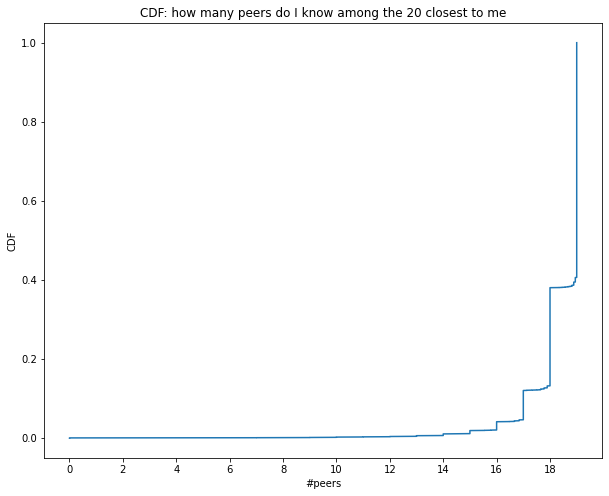

In [217]:
x = np.sort([20*r for r in ratio])
fig = plt.figure(figsize=(10,8))
plt.xticks(np.arange(0, 21, 2))

#calculate CDF values
y = 1. * np.arange(len(ratio)) / (len(ratio) - 1)

#plot CDF
plt.plot(x, y)
plt.xlabel('#peers')
plt.ylabel('CDF')
plt.title('CDF: how many peers do I know among the 20 closest to me')